## 📌 GRU 모델을 이용한 리튬 가격 예측

### 사용변수 : 광물종합지수, 메이저금속지수, 시장전망지표, 무역수지, 환율, 2차전지 산업지수 

In [1]:
#!pip install torchvision

In [2]:
import torch
import torch.nn
import torchvision.transforms as transforms
import torchvision.datasets
from torch.autograd import Variable
from torch.nn import Parameter
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math

import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

In [3]:
plt.style.use('seaborn-whitegrid')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)

if torch.cuda.is_available() :
    torch.cuda.manual_seed_all(125)

C:\Users\wandong\AppData\Local\Temp\ipykernel_3748\1616429856.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## 1. 데이터 형태 확인

In [4]:
import pandas as pd
import numpy as np
df=pd.read_csv('../../../../data/final/리튬data.csv',encoding='cp949')
주식=pd.read_csv('../../../../data/final/주식.csv',encoding='cp949')
df=pd.merge(df,주식,left_on='기준일',right_on='Date',how='left')
df=df[df['기준일']<'2024-05-01']
df

,기준일,기준가격,광물종합지수,희유금속지수,환율,시장전망지표,수산화리튬 수출 중량,수산화리튬 수입 중량,탄산리튬 수출 중량,탄산리튬 수입 중량,...,삼성SDI,LG화학,에코프로비엠,에코프로,sk이노베이션,엘앤에프,코스모신소재,롯데에너지머티리얼즈,솔브레인홀딩스,평균주가
0,2021-06-09,81.0,2407.510943,1682.471447,174.527703,35.06,74.7,5111.1,123.5,4972.3,...,0.550586,0.818009,0.000000,0.002092,0.889477,0.000000,0.000000,0.328393,0.285927,0.319387
1,2021-06-10,81.0,2436.458355,1682.471447,174.807806,35.06,74.7,5111.1,123.5,4972.3,...,0.559105,0.827488,0.004433,0.002511,0.863166,0.006937,0.002379,0.322835,0.281459,0.318924
2,2021-06-11,81.0,2452.915918,1682.471447,173.843528,35.06,74.7,5111.1,123.5,4972.3,...,0.618743,0.909005,0.007149,0.000152,0.889477,0.012713,0.006423,0.338583,0.272524,0.339419
3,2021-06-15,81.0,2496.551463,1741.940418,174.501333,35.06,74.7,5111.1,123.5,4972.3,...,0.650692,0.852133,0.008213,0.000268,0.963163,0.012300,0.004998,0.354331,0.281459,0.347506
4,2021-06-16,81.0,2466.150328,1741.940418,174.243559,35.06,74.7,5111.1,123.5,4972.3,...,0.657082,0.829384,0.010339,0.001330,0.950005,0.009096,0.005946,0.345994,0.280715,0.343321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690,2024-04-24,109.5,2886.010511,1819.964070,189.175230,76.95,38.1,9062.7,746.7,2650.6,...,0.158679,0.020853,0.482357,0.380355,0.033163,0.291067,0.610744,0.150533,0.483246,0.290111
691,2024-04-25,109.5,2895.915528,1819.964070,190.078950,76.95,38.1,9062.7,746.7,2650.6,...,0.140575,0.004739,0.454861,0.399120,0.019791,0.267836,0.600151,0.148680,0.484736,0.280054
692,2024-04-26,109.5,2917.287957,1819.964070,189.497968,76.95,38.1,9062.7,746.7,2650.6,...,0.129925,0.005687,0.459643,0.390736,0.015512,0.279051,0.595818,0.129226,0.481757,0.276373
693,2024-04-29,109.5,2909.741785,1825.673769,190.085029,76.95,38.1,9062.7,746.7,2650.6,...,0.156550,0.047393,0.466816,0.390736,0.047605,0.311494,0.619411,0.135248,0.578555,0.305979


In [5]:
df.isna().sum()

기준일             0
기준가격            0
광물종합지수          0
희유금속지수          0
환율              0
시장전망지표          0
수산화리튬 수출 중량     0
수산화리튬 수입 중량     0
탄산리튬 수출 중량      0
탄산리튬 수입 중량      0
수산화리튬_무역수지      0
탄산리튬_무역수지       0
수급안정화지수         0
Date           23
삼성SDI          23
LG화학           23
에코프로비엠         23
에코프로           23
sk이노베이션        23
엘앤에프           23
코스모신소재         23
롯데에너지머티리얼즈     23
솔브레인홀딩스        23
평균주가           23
dtype: int64

In [6]:
df['수급상태'] = pd.cut(df['수급안정화지수'],
                   bins=[-float('inf'), 1, 5, 20, 80, float('inf')],
                   labels=['수급위기', '수급불안', '수급주의', '수급안정', '공급과잉'])
df['수급상태']

0      수급안정
1      수급안정
2      수급안정
3      수급안정
4      수급안정
       ... 
690    수급안정
691    수급안정
692    수급안정
693    수급안정
694    수급안정
Name: 수급상태, Length: 695, dtype: category
Categories (5, object): ['수급위기' < '수급불안' < '수급주의' < '수급안정' < '공급과잉']

In [7]:
### 41개의 공휴일값들이 존재해서 이전 값으로 채워줌

In [8]:
df.isna().sum()

기준일             0
기준가격            0
광물종합지수          0
희유금속지수          0
환율              0
시장전망지표          0
수산화리튬 수출 중량     0
수산화리튬 수입 중량     0
탄산리튬 수출 중량      0
탄산리튬 수입 중량      0
수산화리튬_무역수지      0
탄산리튬_무역수지       0
수급안정화지수         0
Date           23
삼성SDI          23
LG화학           23
에코프로비엠         23
에코프로           23
sk이노베이션        23
엘앤에프           23
코스모신소재         23
롯데에너지머티리얼즈     23
솔브레인홀딩스        23
평균주가           23
수급상태            0
dtype: int64

In [9]:
df[df['삼성SDI'].isna()]

,기준일,기준가격,광물종합지수,희유금속지수,환율,시장전망지표,수산화리튬 수출 중량,수산화리튬 수입 중량,탄산리튬 수출 중량,탄산리튬 수입 중량,...,LG화학,에코프로비엠,에코프로,sk이노베이션,엘앤에프,코스모신소재,롯데에너지머티리얼즈,솔브레인홀딩스,평균주가,수급상태
47,2021-08-16,96.0,2611.001738,2041.301641,179.324937,43.92,393.2,5194.3,344.1,2775.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,수급안정
72,2021-09-22,154.0,2568.787705,2411.364439,182.944638,32.16,1.9,4579.7,218.9,3025.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,수급안정
78,2021-10-11,173.0,2860.247889,2668.326718,185.582786,10.37,120.3,4520.4,390.2,4566.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,수급주의
137,2021-12-31,264.5,2732.838089,3050.712939,186.734364,12.14,22.4,5888.9,458.9,3671.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,수급주의
173,2022-03-01,452.5,3431.758631,3844.378117,190.369987,1.62,10.0,5408.4,590.2,4793.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,수급불안
179,2022-03-09,467.5,4095.184037,3979.610227,195.186468,1.62,10.0,5408.4,590.2,4793.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,수급불안
215,2022-05-05,427.5,3732.409201,4514.430250,189.405976,2.96,0.0,5922.3,825.3,4770.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,수급불안
234,2022-06-01,439.5,3763.592951,4361.376925,186.120478,3.40,1.9,8364.4,664.7,4297.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,수급불안
236,2022-06-06,447.5,3725.586595,4375.435525,187.787013,3.40,1.9,8364.4,664.7,4297.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,수급불안
286,2022-08-15,464.5,3339.464534,3926.479594,193.031540,9.08,5.5,6030.4,912.8,4750.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,수급주의


In [10]:
주식.head(3)

,Date,삼성SDI,LG화학,에코프로비엠,에코프로,sk이노베이션,엘앤에프,코스모신소재,롯데에너지머티리얼즈,솔브레인홀딩스,평균주가
0,2021-06-09,0.550586,0.818009,0.000000,0.002092,0.889477,0.000000,0.000000,0.328393,0.285927,0.319387
1,2021-06-10,0.559105,0.827488,0.004433,0.002511,0.863166,0.006937,0.002379,0.322835,0.281459,0.318924
2,2021-06-11,0.618743,0.909005,0.007149,0.000152,0.889477,0.012713,0.006423,0.338583,0.272524,0.339419


In [11]:
df.ffill(inplace=True)
df

,기준일,기준가격,광물종합지수,희유금속지수,환율,시장전망지표,수산화리튬 수출 중량,수산화리튬 수입 중량,탄산리튬 수출 중량,탄산리튬 수입 중량,...,LG화학,에코프로비엠,에코프로,sk이노베이션,엘앤에프,코스모신소재,롯데에너지머티리얼즈,솔브레인홀딩스,평균주가,수급상태
0,2021-06-09,81.0,2407.510943,1682.471447,174.527703,35.06,74.7,5111.1,123.5,4972.3,...,0.818009,0.000000,0.002092,0.889477,0.000000,0.000000,0.328393,0.285927,0.319387,수급안정
1,2021-06-10,81.0,2436.458355,1682.471447,174.807806,35.06,74.7,5111.1,123.5,4972.3,...,0.827488,0.004433,0.002511,0.863166,0.006937,0.002379,0.322835,0.281459,0.318924,수급안정
2,2021-06-11,81.0,2452.915918,1682.471447,173.843528,35.06,74.7,5111.1,123.5,4972.3,...,0.909005,0.007149,0.000152,0.889477,0.012713,0.006423,0.338583,0.272524,0.339419,수급안정
3,2021-06-15,81.0,2496.551463,1741.940418,174.501333,35.06,74.7,5111.1,123.5,4972.3,...,0.852133,0.008213,0.000268,0.963163,0.012300,0.004998,0.354331,0.281459,0.347506,수급안정
4,2021-06-16,81.0,2466.150328,1741.940418,174.243559,35.06,74.7,5111.1,123.5,4972.3,...,0.829384,0.010339,0.001330,0.950005,0.009096,0.005946,0.345994,0.280715,0.343321,수급안정
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690,2024-04-24,109.5,2886.010511,1819.964070,189.175230,76.95,38.1,9062.7,746.7,2650.6,...,0.020853,0.482357,0.380355,0.033163,0.291067,0.610744,0.150533,0.483246,0.290111,수급안정
691,2024-04-25,109.5,2895.915528,1819.964070,190.078950,76.95,38.1,9062.7,746.7,2650.6,...,0.004739,0.454861,0.399120,0.019791,0.267836,0.600151,0.148680,0.484736,0.280054,수급안정
692,2024-04-26,109.5,2917.287957,1819.964070,189.497968,76.95,38.1,9062.7,746.7,2650.6,...,0.005687,0.459643,0.390736,0.015512,0.279051,0.595818,0.129226,0.481757,0.276373,수급안정
693,2024-04-29,109.5,2909.741785,1825.673769,190.085029,76.95,38.1,9062.7,746.7,2650.6,...,0.047393,0.466816,0.390736,0.047605,0.311494,0.619411,0.135248,0.578555,0.305979,수급안정


In [12]:
df.isna().sum()

기준일            0
기준가격           0
광물종합지수         0
희유금속지수         0
환율             0
시장전망지표         0
수산화리튬 수출 중량    0
수산화리튬 수입 중량    0
탄산리튬 수출 중량     0
탄산리튬 수입 중량     0
수산화리튬_무역수지     0
탄산리튬_무역수지      0
수급안정화지수        0
Date           0
삼성SDI          0
LG화학           0
에코프로비엠         0
에코프로           0
sk이노베이션        0
엘앤에프           0
코스모신소재         0
롯데에너지머티리얼즈     0
솔브레인홀딩스        0
평균주가           0
수급상태           0
dtype: int64

In [13]:
df.rename(columns={'기준일':'DATE'},inplace=True)
data=df['DATE']
df.set_index('DATE',inplace=True)
# df.drop('Unnamed: 0',axis=1,inplace=True)
df

,기준가격,광물종합지수,희유금속지수,환율,시장전망지표,수산화리튬 수출 중량,수산화리튬 수입 중량,탄산리튬 수출 중량,탄산리튬 수입 중량,수산화리튬_무역수지,...,LG화학,에코프로비엠,에코프로,sk이노베이션,엘앤에프,코스모신소재,롯데에너지머티리얼즈,솔브레인홀딩스,평균주가,수급상태
DATE,,,,,,,,,,,,,,,,,,,,,
2021-06-09,81.0,2407.510943,1682.471447,174.527703,35.06,74.7,5111.1,123.5,4972.3,-59756,...,0.818009,0.000000,0.002092,0.889477,0.000000,0.000000,0.328393,0.285927,0.319387,수급안정
2021-06-10,81.0,2436.458355,1682.471447,174.807806,35.06,74.7,5111.1,123.5,4972.3,-59756,...,0.827488,0.004433,0.002511,0.863166,0.006937,0.002379,0.322835,0.281459,0.318924,수급안정
2021-06-11,81.0,2452.915918,1682.471447,173.843528,35.06,74.7,5111.1,123.5,4972.3,-59756,...,0.909005,0.007149,0.000152,0.889477,0.012713,0.006423,0.338583,0.272524,0.339419,수급안정
2021-06-15,81.0,2496.551463,1741.940418,174.501333,35.06,74.7,5111.1,123.5,4972.3,-59756,...,0.852133,0.008213,0.000268,0.963163,0.012300,0.004998,0.354331,0.281459,0.347506,수급안정
2021-06-16,81.0,2466.150328,1741.940418,174.243559,35.06,74.7,5111.1,123.5,4972.3,-59756,...,0.829384,0.010339,0.001330,0.950005,0.009096,0.005946,0.345994,0.280715,0.343321,수급안정
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-24,109.5,2886.010511,1819.964070,189.175230,76.95,38.1,9062.7,746.7,2650.6,-144357,...,0.020853,0.482357,0.380355,0.033163,0.291067,0.610744,0.150533,0.483246,0.290111,수급안정
2024-04-25,109.5,2895.915528,1819.964070,190.078950,76.95,38.1,9062.7,746.7,2650.6,-144357,...,0.004739,0.454861,0.399120,0.019791,0.267836,0.600151,0.148680,0.484736,0.280054,수급안정
2024-04-26,109.5,2917.287957,1819.964070,189.497968,76.95,38.1,9062.7,746.7,2650.6,-144357,...,0.005687,0.459643,0.390736,0.015512,0.279051,0.595818,0.129226,0.481757,0.276373,수급안정


In [14]:
df.isna().sum()

기준가격           0
광물종합지수         0
희유금속지수         0
환율             0
시장전망지표         0
수산화리튬 수출 중량    0
수산화리튬 수입 중량    0
탄산리튬 수출 중량     0
탄산리튬 수입 중량     0
수산화리튬_무역수지     0
탄산리튬_무역수지      0
수급안정화지수        0
Date           0
삼성SDI          0
LG화학           0
에코프로비엠         0
에코프로           0
sk이노베이션        0
엘앤에프           0
코스모신소재         0
롯데에너지머티리얼즈     0
솔브레인홀딩스        0
평균주가           0
수급상태           0
dtype: int64

In [15]:
drop_columns=['기준가격','수산화리튬 수출 중량','수산화리튬 수입 중량','탄산리튬 수입 중량','탄산리튬 수출 중량',
             '삼성SDI','LG화학','에코프로비엠','에코프로','sk이노베이션','엘앤에프','코스모신소재',
             '롯데에너지머티리얼즈','솔브레인홀딩스','Date','수급안정화지수','수급상태']

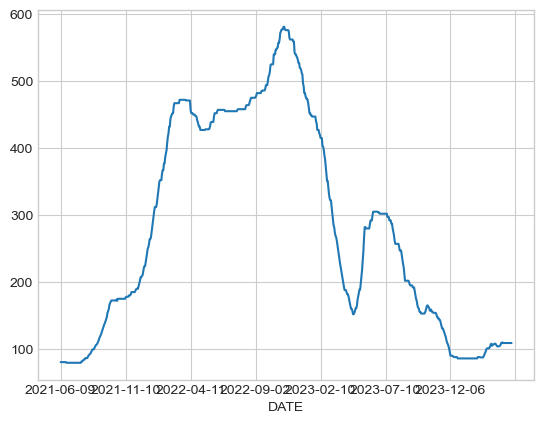

In [16]:
fig = df['기준가격'].plot()

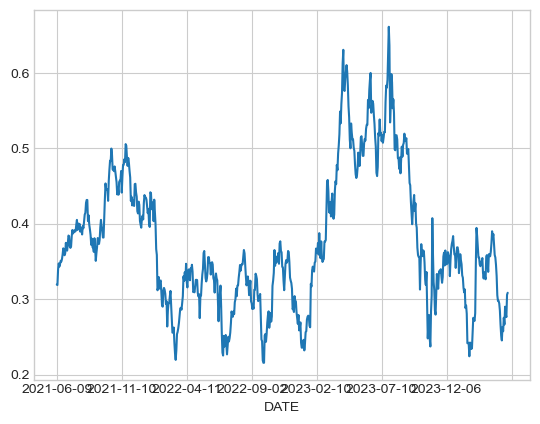

In [17]:
fig = df['평균주가'].plot()

In [18]:
X = df.drop(drop_columns, axis=1) # X, y 분리
y = df[['기준가격']]

In [19]:
y

,기준가격
DATE,
2021-06-09,81.0
2021-06-10,81.0
2021-06-11,81.0
2021-06-15,81.0
2021-06-16,81.0
...,...
2024-04-24,109.5
2024-04-25,109.5
2024-04-26,109.5


In [20]:
X.fillna(0,inplace=True)
X.isna().sum()
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 695 entries, 2021-06-09 to 2024-04-30
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   광물종합지수      695 non-null    float64
 1   희유금속지수      695 non-null    float64
 2   환율          695 non-null    float64
 3   시장전망지표      695 non-null    float64
 4   수산화리튬_무역수지  695 non-null    int64  
 5   탄산리튬_무역수지   695 non-null    int64  
 6   평균주가        695 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 43.4+ KB


In [21]:
X

,광물종합지수,희유금속지수,환율,시장전망지표,수산화리튬_무역수지,탄산리튬_무역수지,평균주가
DATE,,,,,,,
2021-06-09,2407.510943,1682.471447,174.527703,35.06,-59756,-47671,0.319387
2021-06-10,2436.458355,1682.471447,174.807806,35.06,-59756,-47671,0.318924
2021-06-11,2452.915918,1682.471447,173.843528,35.06,-59756,-47671,0.339419
2021-06-15,2496.551463,1741.940418,174.501333,35.06,-59756,-47671,0.347506
2021-06-16,2466.150328,1741.940418,174.243559,35.06,-59756,-47671,0.343321
...,...,...,...,...,...,...,...
2024-04-24,2886.010511,1819.964070,189.175230,76.95,-144357,-41877,0.290111
2024-04-25,2895.915528,1819.964070,190.078950,76.95,-144357,-41877,0.280054
2024-04-26,2917.287957,1819.964070,189.497968,76.95,-144357,-41877,0.276373


## 2. 8:2 로 train test 분리

In [22]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

ms = MinMaxScaler() # 0 ~ 1
ss = StandardScaler() # 평균 0, 분산 1

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:688, :] 
X_test = X_ss[688:, :]

y_train = y_ms[:688, :]
y_test = y_ms[688:, :]

print('Training Shape :', X_train.shape, y_train.shape)
print('Testing Shape :', X_test.shape, y_test.shape)

Training Shape : (688, 7) (688, 1)
Testing Shape : (7, 7) (7, 1)


In [23]:
# 데이터셋 형태 및 크기 조정
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, 
                                  (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))

X_test_tensors_f = torch.reshape(X_test_tensors,
                                (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print('Training Shape :', X_train.shape, y_train.shape)
print('Testing Shape :', X_test.shape, y_test.shape)

Training Shape : (688, 7) (688, 1)
Testing Shape : (7, 7) (7, 1)


## 3. GRU모델 설정

In [24]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class GRU(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length, dropout_prob=0.0):
        super(GRU, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.dropout = nn.Dropout(p=dropout_prob)  # Dropout layer added
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        output, (hn) = self.gru(x, (h_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.dropout(out)  # Applying dropout before the final fully connected layer
        out = self.fc(out)
        return out


In [25]:
num_epochs = 2000
learning_rate = 0.0005
dropout_prob = 0.7

input_size=7
hidden_size=55
num_layers=1

num_classes=1

model=GRU(num_classes,input_size,hidden_size,num_layers,X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [26]:
for epoch in range(num_epochs) :
    outputs = model.forward(X_train_tensors_f) # 전방향 학습
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors) # 오차 계산
    loss.backward() # 기울기 계산
    
    optimizer.step() # 오차 업데이트
    if epoch % 100 == 0 :
        print(f'Epoch : {epoch}, loss : {loss.item():1.5f}')

Epoch : 0, loss : 0.29934
Epoch : 100, loss : 0.01087
Epoch : 200, loss : 0.00326
Epoch : 300, loss : 0.00126
Epoch : 400, loss : 0.00083
Epoch : 500, loss : 0.00063
Epoch : 600, loss : 0.00050
Epoch : 700, loss : 0.00040
Epoch : 800, loss : 0.00034
Epoch : 900, loss : 0.00028
Epoch : 1000, loss : 0.00025
Epoch : 1100, loss : 0.00022
Epoch : 1200, loss : 0.00019
Epoch : 1300, loss : 0.00017
Epoch : 1400, loss : 0.00016
Epoch : 1500, loss : 0.00014
Epoch : 1600, loss : 0.00013
Epoch : 1700, loss : 0.00012
Epoch : 1800, loss : 0.00012
Epoch : 1900, loss : 0.00011


In [27]:
df_x_ss = ss.transform(X)
df_y_ms = ms.transform(y)

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

## 4. 예측된 주식 값과 실제 주식 값을 시각화

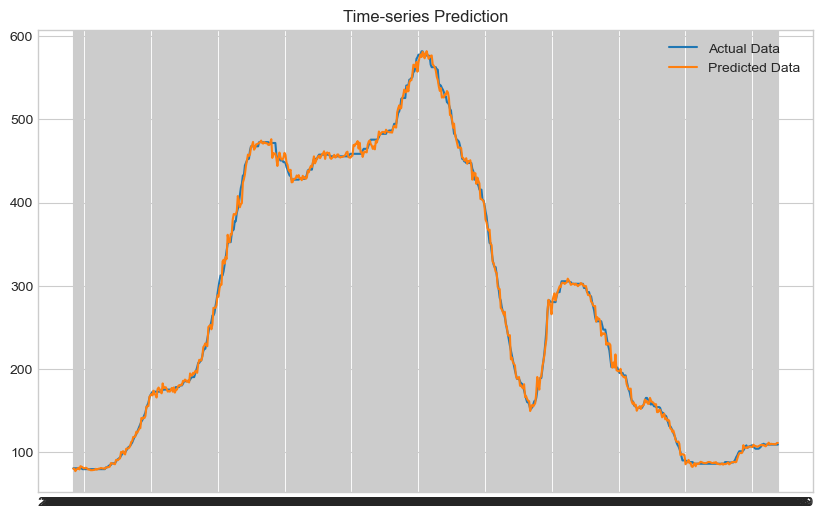

In [28]:
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()

label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10, 6))
# plt.axvline(x=datetime(2022,5,1), c='r', linestyle='--')

df['pred'] = predicted
plt.plot(df['기준가격'], label='Actual Data')
plt.plot(df['pred'], label='Predicted Data')

plt.title('Time-series Prediction')
plt.legend()
plt.show()

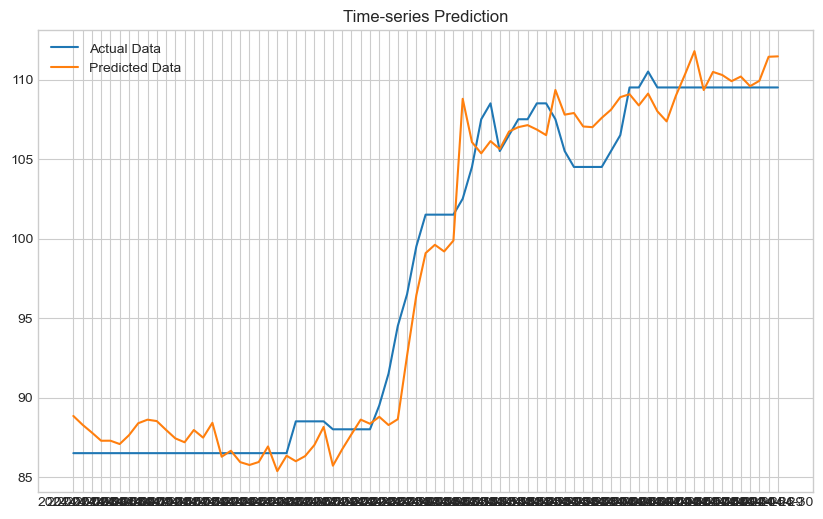

In [29]:
new_df=df.loc['2024-01-01':'2024-05-20']

new_df

plt.figure(figsize=(10, 6))

plt.plot(new_df['기준가격'], label='Actual Data')
plt.plot(new_df['pred'], label='Predicted Data')

plt.title('Time-series Prediction')
plt.legend()
plt.show()

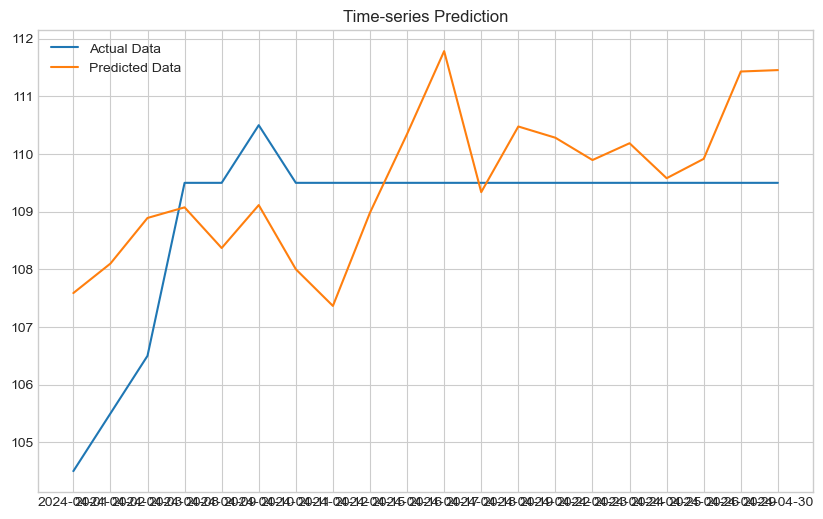

In [30]:
new_df=df.loc['2024-04-01':'2024-04-30']

new_df

plt.figure(figsize=(10, 6))

plt.plot(new_df['기준가격'], label='Actual Data')
plt.plot(new_df['pred'], label='Predicted Data')

plt.title('Time-series Prediction')
plt.legend()
plt.show()

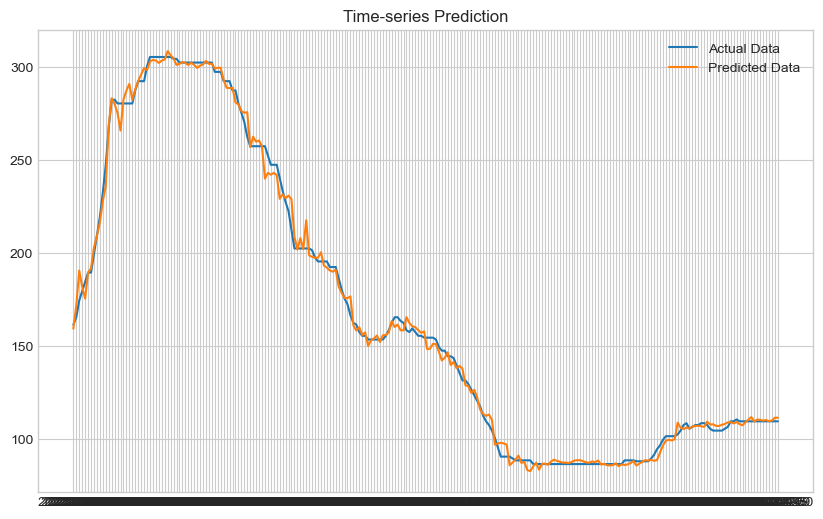

In [31]:
new_df=df.loc['2023-04-30':'2024-04-30']

new_df

plt.figure(figsize=(10, 6))

plt.plot(new_df['기준가격'], label='Actual Data')
plt.plot(new_df['pred'], label='Predicted Data')

plt.title('Time-series Prediction')
plt.legend()
plt.show()

## 5. RMSE 계산

In [32]:
from sklearn.metrics import mean_squared_error
import numpy as np

# 예측값과 실제값을 NumPy 배열로 변환
predicted = np.array(df['pred'])
actual = np.array(df['기준가격'])

# RMSE 계산
rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f'RMSE: {rmse}')


RMSE: 5.038240279467426


## 6. 데이터 내보내기

In [33]:
df

,기준가격,광물종합지수,희유금속지수,환율,시장전망지표,수산화리튬 수출 중량,수산화리튬 수입 중량,탄산리튬 수출 중량,탄산리튬 수입 중량,수산화리튬_무역수지,...,에코프로비엠,에코프로,sk이노베이션,엘앤에프,코스모신소재,롯데에너지머티리얼즈,솔브레인홀딩스,평균주가,수급상태,pred
DATE,,,,,,,,,,,,,,,,,,,,,
2021-06-09,81.0,2407.510943,1682.471447,174.527703,35.06,74.7,5111.1,123.5,4972.3,-59756,...,0.000000,0.002092,0.889477,0.000000,0.000000,0.328393,0.285927,0.319387,수급안정,80.603096
2021-06-10,81.0,2436.458355,1682.471447,174.807806,35.06,74.7,5111.1,123.5,4972.3,-59756,...,0.004433,0.002511,0.863166,0.006937,0.002379,0.322835,0.281459,0.318924,수급안정,80.539742
2021-06-11,81.0,2452.915918,1682.471447,173.843528,35.06,74.7,5111.1,123.5,4972.3,-59756,...,0.007149,0.000152,0.889477,0.012713,0.006423,0.338583,0.272524,0.339419,수급안정,77.607399
2021-06-15,81.0,2496.551463,1741.940418,174.501333,35.06,74.7,5111.1,123.5,4972.3,-59756,...,0.008213,0.000268,0.963163,0.012300,0.004998,0.354331,0.281459,0.347506,수급안정,79.633125
2021-06-16,81.0,2466.150328,1741.940418,174.243559,35.06,74.7,5111.1,123.5,4972.3,-59756,...,0.010339,0.001330,0.950005,0.009096,0.005946,0.345994,0.280715,0.343321,수급안정,80.307167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-24,109.5,2886.010511,1819.964070,189.175230,76.95,38.1,9062.7,746.7,2650.6,-144357,...,0.482357,0.380355,0.033163,0.291067,0.610744,0.150533,0.483246,0.290111,수급안정,110.186691
2024-04-25,109.5,2895.915528,1819.964070,190.078950,76.95,38.1,9062.7,746.7,2650.6,-144357,...,0.454861,0.399120,0.019791,0.267836,0.600151,0.148680,0.484736,0.280054,수급안정,109.580269
2024-04-26,109.5,2917.287957,1819.964070,189.497968,76.95,38.1,9062.7,746.7,2650.6,-144357,...,0.459643,0.390736,0.015512,0.279051,0.595818,0.129226,0.481757,0.276373,수급안정,109.916039


In [34]:
# df.to_csv('../../results/리튬lstm.csv',encoding='cp949')